Dask dashboard link: http://10.0.0.5:8787/status
Persisting data cube to Dask cluster...
Data loaded successfully.
Computing data before saving...
Data cube saved to ../../data/germany_flood_cache.nc
Loading data from ../../data/germany_flood_cache.nc...
Data loaded successfully from ../../data/germany_flood_cache.nc
  - Bounding box: [12.3 54.3 13.1 54.6]
  - Time range: 2023-10-11/2023-10-25
  - CRS: PROJCS["Azimuthal_Equidistant",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["latitude_of_center",53],PARAMETER["longitude_of_center",24],PARAMETER["false_easting",5837287.81977],PARAMETER["false_northing",2121415.69617],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
  - Resolution: 20
Swath mosaic applied to 12 variable(s).
['dlr_likelihood', 'tuw_likelihood', 'list_likelihood', 'dlr_floo

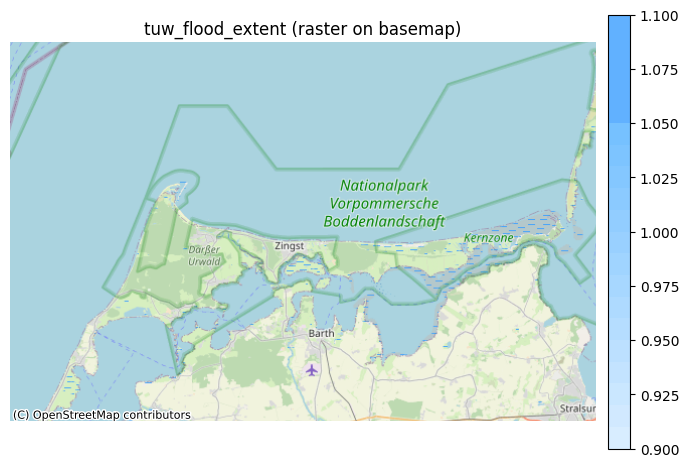

Building polygons for 'tuw_flood_extent'...
  Filling holes in polygons...
  Smoothing polygons...
    Using projected CRS, buffer distance: 0.01 units
Polygons built successfully for 'tuw_flood_extent'. Found 746 polygon(s).


c:\Users\jonas\anaconda3\envs\earth_oberservations\Lib\site-packages\contextily\tile.py:662: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


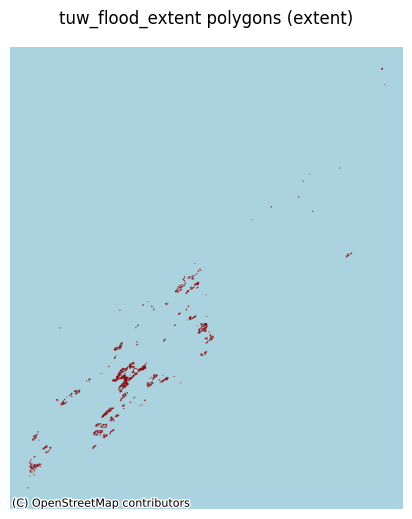

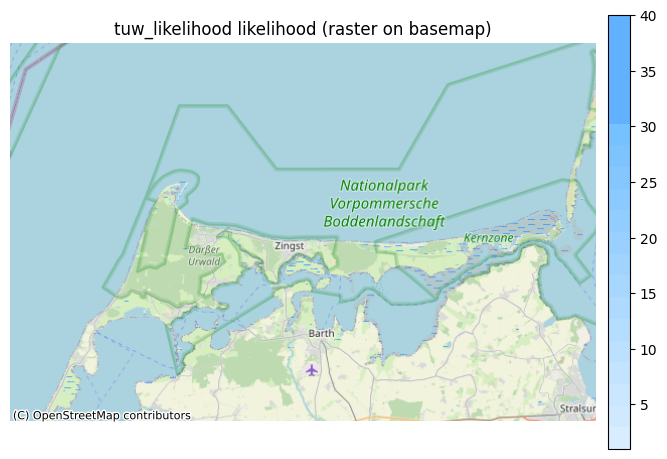

C:\Users\jonas\AppData\Local\Temp\ipykernel_15432\839366988.py:159: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x_cent = gdf4326.geometry.centroid.x.values
C:\Users\jonas\AppData\Local\Temp\ipykernel_15432\839366988.py:160: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  y_cent = gdf4326.geometry.centroid.y.values
c:\Users\jonas\anaconda3\envs\earth_oberservations\Lib\site-packages\contextily\tile.py:662: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


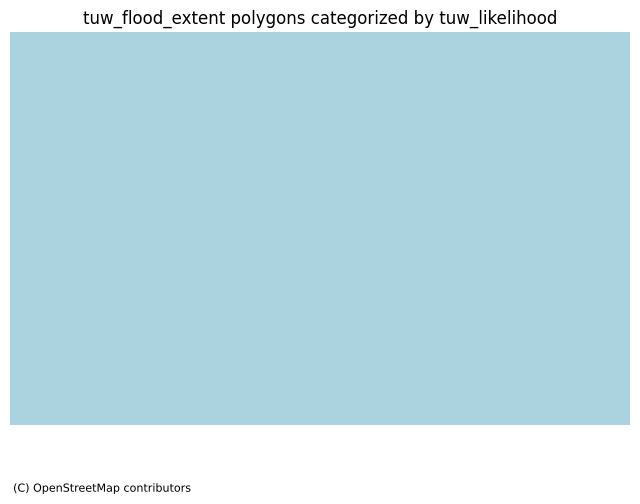

{'baseline_no_map': '..\\..\\visualizations\\jonas\\outputs\\01_baseline_no_map_tuw_flood_extent.png',
 'baseline_with_map': '..\\..\\visualizations\\jonas\\outputs\\02_baseline_with_map_tuw_flood_extent.png',
 'polygons_extent': '..\\..\\visualizations\\jonas\\outputs\\03_polygons_extent_tuw_flood_extent.png',
 'likelihood_raster': '..\\..\\visualizations\\jonas\\outputs\\03b_likelihood_tuw_likelihood.png',
 'polygons_categories': '..\\..\\visualizations\\jonas\\outputs\\04_polygons_categories_tuw_flood_extent_tuw_likelihood.png'}

In [ ]:
import pystac_client
from dask.distributed import Client
import sys
from pathlib import Path
from matplotlib.colors import ListedColormap
sys.path.append(str(Path.cwd() / "dynamic-flood-visualization" / "src"))

project_root = Path.cwd().parent.parent  # goes from visualizations/jonas -> visualizations -> project root
src_path = project_root / "src"
assert src_path.exists(), f"src path not found: {src_path}"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from dcloader import DcLoader
#from dynamic-flood-visualization.src.dcloader import DcLoader
import matplotlib.pyplot as plt
import xarray as xr
from mapvisualiser import MapVisualiser
import rioxarray
import hvplot.xarray
from color_schemes import COLOR_PALETTES

cache_file = '../../data/germany_flood_cache.nc'
eodc_catalog = pystac_client.Client.open("https://stac.eodc.eu/api/v1/")
time_range_germany = '2022-09-23T01:25:51Z/2022-09-23T01:25:52Z'
time_range = "2023-10-11/2023-10-25"
time_range_germany = time_range
minlon, maxlon = 12.3, 13.1
minlat, maxlat = 54.3, 54.6
bounding_box = [minlon, minlat, maxlon, maxlat]
bounding_box_germany = bounding_box

client = Client(processes=False, threads_per_worker=2, n_workers=3, memory_limit="12GB")
print(f"Dask dashboard link: {client.dashboard_link}")
dc_loader = DcLoader(eodc_catalog)
dc_loader.load_GFM_data(time_range_germany, bounding_box_germany)
# dc must be saved and loaded again as we want to store it directly at the MaVisualiser
# as we don't want to 
flood_variables = ['dlr_likelihood', 'tuw_likelihood', 'list_likelihood', 'dlr_flood_extent', 'tuw_flood_extent', 'list_flood_extent', 'ensemble_likelihood', 'ensemble_flood_extent', 'ensemble_water_extent']
mask_variables = ['reference_water_mask', 'exclusion_mask', 'advisory_flags']
#dc_loader.compute_swath_mosaic(flood_variables=flood_variables, mask_variables=mask_variables, debug=True, persist=True)
dc_loader.save_to_netcdf(cache_file)
client.close()
dc_loader =  DcLoader(eodc_catalog, netcdf_path=cache_file)
dc_loader.compute_swath_mosaic(flood_variables=flood_variables, mask_variables=mask_variables, debug=False, persist=True)

## Creating MapVisualiser instance 
visualiser = MapVisualiser(dcloader_instance=dc_loader)
visualiser.flood_variables = [var for var in visualiser.flood_variables if var != 'spatial_ref' ]
print(visualiser.flood_variables)
print(visualiser)

import contextily as cx
from matplotlib.colors import ListedColormap
from pathlib import Path
import matplotlib.pyplot as plt

def save_germany_visualizations(
    visualiser,
    base_var: str,
    like_var: str,
    out_dir: str,
    thresholds=(0.33, 0.66),
    tiles='OSM'  # kept for signature; not used
):
    # Enforce the same basemap everywhere
    basemap = cx.providers.OpenStreetMap.Mapnik

    Path(out_dir).mkdir(parents=True, exist_ok=True)

    # Ensure inputs
    if base_var not in visualiser.refined_data:
        visualiser.select_and_refine_variable(base_var)
    if base_var not in visualiser.plottable_data:
        visualiser.prepare_for_map_overlay(base_var, save_to_plottable=True)
    if like_var not in visualiser.plottable_data:
        visualiser.prepare_for_map_overlay(like_var, save_to_plottable=True)

    # 1) Baseline: refined raster (no basemap)
    fig1 = visualiser.plot_refined_data(
        variable_name=base_var,
        cmap=COLOR_PALETTES['light_to_strong_blue']
    )
    fig1_path = Path(out_dir) / f"01_baseline_no_map_{base_var}.png"
    fig1.savefig(fig1_path, dpi=200)
    plt.show()
    plt.close(fig1)

    # Helper: plot raster over basemap with Matplotlib + contextily (Mapnik)
    def save_raster_on_basemap(da, title, out_path, cmap_list_or_name):
        cmap_obj = ListedColormap(cmap_list_or_name) if isinstance(cmap_list_or_name, (list, tuple)) else cmap_list_or_name
        da3857 = da.rio.reproject("EPSG:3857")
        x = da3857.coords["x"].values
        y = da3857.coords["y"].values
        extent = [x.min(), x.max(), y.min(), y.max()]
        fig, ax = plt.subplots(figsize=(8, 6))
        im = ax.imshow(
            da3857.values,
            extent=extent,
            origin="upper",
            cmap=cmap_obj,
            alpha=0.7
        )
        cx.add_basemap(ax, source=basemap, crs="EPSG:3857")
        ax.set_title(title)
        ax.set_axis_off()
        cbar = plt.colorbar(im, ax=ax, fraction=0.035, pad=0.02)
        cbar.ax.set_ylabel("")
        fig.savefig(out_path, dpi=200, bbox_inches="tight")
        plt.show()
        plt.close(fig)

    # 2) Baseline with map: plottable raster
    da_base = visualiser.plottable_data[base_var]
    map2_path = Path(out_dir) / f"02_baseline_with_map_{base_var}.png"
    save_raster_on_basemap(
        da_base,
        f"{base_var} (raster on basemap)",
        map2_path,
        COLOR_PALETTES['light_to_strong_blue']
    )

    # Ensure polygons for base_var
    if base_var not in visualiser.polygons_data:
        visualiser.build_polygons(base_var, smooth_distance=0.01, save_to_polygons=True)

    # 3a) Polygons (extent) over basemap — Mapnik
    gdf = visualiser.polygons_data[base_var]
    gdf3857 = gdf.to_crs("EPSG:3857")
    poly3_path = Path(out_dir) / f"03_polygons_extent_{base_var}.png"
    fig3, ax3 = plt.subplots(figsize=(8, 6))
    gdf3857.plot(ax=ax3, facecolor="none", edgecolor="darkred", linewidth=0.7, alpha=0.7)
    cx.add_basemap(ax3, source=basemap, crs="EPSG:3857")
    ax3.set_title(f"{base_var} polygons (extent)")
    ax3.set_axis_off()
    fig3.savefig(poly3_path, dpi=200, bbox_inches="tight")#
    plt.show()
    plt.close(fig3)

    # 3b) Likelihood raster over basemap — Mapnik
    da_like = visualiser.plottable_data[like_var]
    like_map_path = Path(out_dir) / f"03b_likelihood_{like_var}.png"
    save_raster_on_basemap(
        da_like,
        f"{like_var} likelihood (raster on basemap)",
        like_map_path,
        COLOR_PALETTES['light_to_strong_blue']
    )

    # 4) Polygons categorized by likelihood — Mapnik
    low, high = thresholds
    like_da = da_like.fillna(-1)
    cats = (
        (like_da < low) * 0
        + ((like_da >= low) & (like_da < high)) * 1
        + (like_da >= high) * 2
    ).where(like_da >= 0)
    gdf4326 = gdf.to_crs("EPSG:4326")
    x_cent = gdf4326.geometry.centroid.x.values
    y_cent = gdf4326.geometry.centroid.y.values
    xs = cats.coords["x"].values
    ys = cats.coords["y"].values

    def nearest_idx(val, arr):
        import numpy as np
        return int(np.clip(np.argmin(np.abs(arr - val)), 0, len(arr) - 1))

    import numpy as np
    cat_vals = []
    vals = cats.values
    for xi, yi in zip(x_cent, y_cent):
        ix = nearest_idx(xi, xs)
        iy = nearest_idx(yi, ys)
        v = vals[iy, ix]
        cat_vals.append(int(v) if not np.isnan(v) else None)

    gdf4326["category"] = cat_vals
    gdf3857_cat = gdf4326.to_crs("EPSG:3857")

    category_colors = {
        0: "#4daf4a",  # low
        1: "#ffcc00",  # medium
        2: "#e41a1c",  # high
    }
    gdf3857_cat["color"] = gdf3857_cat["category"].map(category_colors)

    poly4_path = Path(out_dir) / f"04_polygons_categories_{base_var}_{like_var}.png"
    fig4, ax4 = plt.subplots(figsize=(8, 6))
    for cat, color in category_colors.items():
        sub = gdf3857_cat[gdf3857_cat["category"] == cat]
        if len(sub) > 0:
            sub.plot(ax=ax4, facecolor=color, edgecolor="black", linewidth=0.5, alpha=0.6, label={0:'Low',1:'Medium',2:'High'}[cat])
    cx.add_basemap(ax4, source=basemap, crs="EPSG:3857")
    ax4.set_title(f"{base_var} polygons categorized by {like_var}")
    ax4.set_axis_off()
    handles, labels = ax4.get_legend_handles_labels()
    if handles:
        ax4.legend(loc="lower left", frameon=True)
    fig4.savefig(poly4_path, dpi=200, bbox_inches="tight")
    plt.show()
    plt.close(fig4)

    return {
        "baseline_no_map": str(fig1_path),
        "baseline_with_map": str(map2_path),
        "polygons_extent": str(poly3_path),
        "likelihood_raster": str(like_map_path),
        "polygons_categories": str(poly4_path),
    }

visualiser.select_and_refine_all_vars()
# out_paths = save_germany_visualizations(
#     visualiser=visualiser,
#     base_var='tuw_flood_extent',                 
#     like_var='tuw_likelihood',               # or 'ensemble_likelihood'
#     out_dir='../../visualizations/jonas/outputs',
#     thresholds=(0.33, 0.66),
#     tiles='OSM'
# )
# out_paths

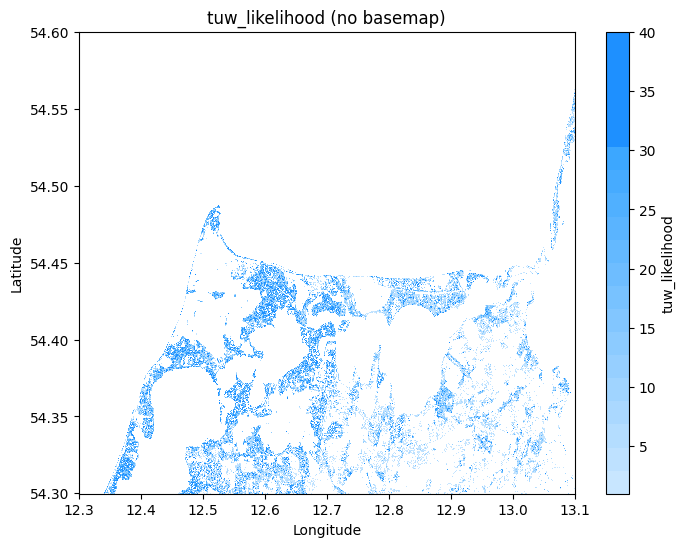

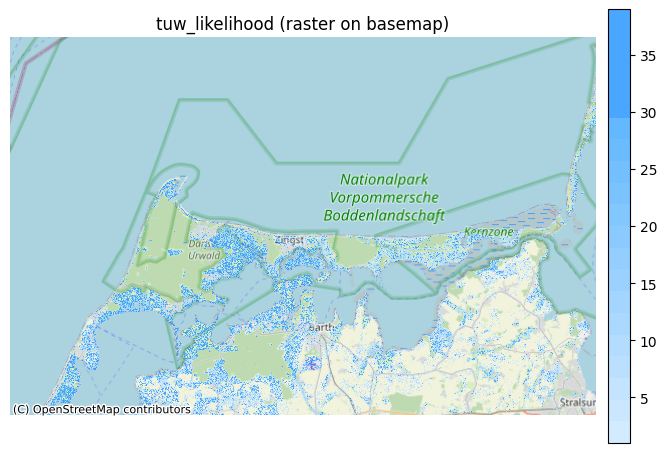

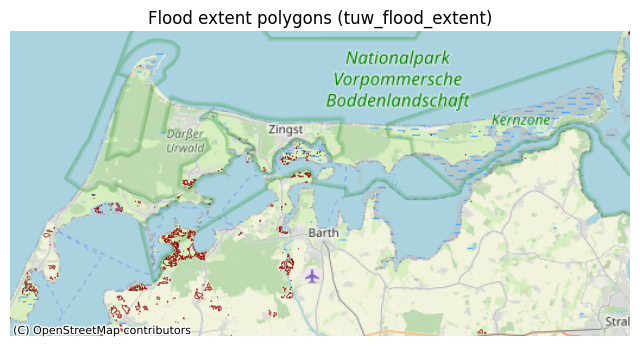

Building polygons for 'tuw_likelihood_mask'...
  Filling holes in polygons...
  Smoothing polygons...
    Using projected CRS, buffer distance: 0.01 units
Polygons built successfully for 'tuw_likelihood_mask'. Found 22848 polygon(s).


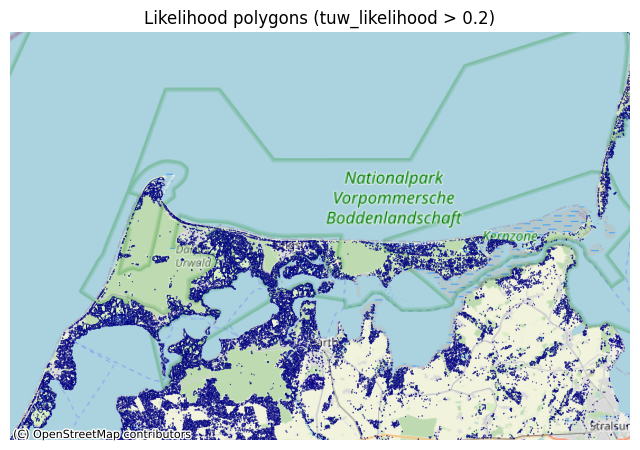

C:\Users\jonas\AppData\Local\Temp\ipykernel_15432\2395723226.py:170: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x_cent = gdf_like_wgs84.geometry.centroid.x.values
C:\Users\jonas\AppData\Local\Temp\ipykernel_15432\2395723226.py:171: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  y_cent = gdf_like_wgs84.geometry.centroid.y.values


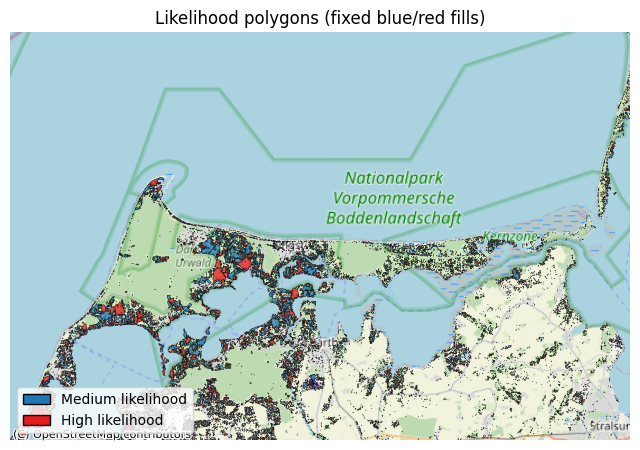

{'01_no_map_likelihood': '..\\..\\visualizations\\jonas\\outputs\\01_tuw_likelihood_no_map.png',
 '02_with_map_likelihood': '..\\..\\visualizations\\jonas\\outputs\\02_tuw_likelihood_with_map.png',
 '03_polygons_flood_extent': '..\\..\\visualizations\\jonas\\outputs\\03_polygons_flood_extent.png',
 '04_polygons_likelihood': '..\\..\\visualizations\\jonas\\outputs\\04_polygons_likelihood.png',
 '05_polygons_binned_likelihood_x_extent': '..\\..\\visualizations\\jonas\\outputs\\05_polygons_binned_likelihood_x_flood_extent.png'}

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import contextily as cx
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import numpy as np

out_dir = Path('../../visualizations/jonas/outputs')
out_dir.mkdir(parents=True, exist_ok=True)

base_var = 'tuw_flood_extent'
like_var = 'tuw_likelihood'
thresholds = (15, 33)
basemap = cx.providers.OpenStreetMap.Mapnik

# Ensure inputs ready
if base_var not in visualiser.refined_data:
    visualiser.select_and_refine_variable(base_var)
if base_var not in visualiser.plottable_data:
    visualiser.prepare_for_map_overlay(base_var, save_to_plottable=True)
if like_var not in visualiser.plottable_data:
    visualiser.prepare_for_map_overlay(like_var, save_to_plottable=True)

def force_wgs84_polygons(gdf):
    """Override stored CRS when coordinates already look like lon/lat."""
    gdf = gdf.copy()
    if len(gdf) == 0:
        return gdf.set_crs("EPSG:4326", allow_override=True)
    bounds = gdf.total_bounds
    looks_like_degrees = np.all(np.abs(bounds) < 400)
    if gdf.crs is None:
        return gdf.set_crs("EPSG:4326", allow_override=True)
    if gdf.crs.is_projected and looks_like_degrees:
        return gdf.set_crs("EPSG:4326", allow_override=True)
    if gdf.crs.to_epsg() != 4326:
        return gdf.to_crs("EPSG:4326")
    return gdf

def to_web_mercator(gdf):
    return force_wgs84_polygons(gdf).to_crs("EPSG:3857")

# 1) tuw_likelihood without background map
fig1, ax1 = plt.subplots(figsize=(8, 6))
visualiser.plottable_data[like_var].plot(ax=ax1, cmap=ListedColormap(COLOR_PALETTES['light_to_strong_blue']))
ax1.set_title('tuw_likelihood (no basemap)')
ax1.set_xlabel('Longitude'); ax1.set_ylabel('Latitude')
fig1_path = out_dir / "01_tuw_likelihood_no_map.png"
fig1.savefig(fig1_path, dpi=200, bbox_inches='tight')
plt.show(); plt.close(fig1)

def save_raster_on_basemap(da, title, out_path, cmap_list_or_name, basemap_src=basemap, alpha=0.6):
    if not da.rio.crs:
        da = da.rio.write_crs("EPSG:4326")
    da3857 = da.rio.reproject("EPSG:3857")
    arr = da3857.values
    marr = np.ma.masked_invalid(arr)
    marr = np.ma.masked_where(arr <= 0, marr)

    if marr.count() > 0:
        vmin = float(np.percentile(marr.compressed(), 2))
        vmax = float(np.percentile(marr.compressed(), 98))
        if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
            vmin = float(np.nanmin(arr))
            vmax = float(np.nanmax(arr))
    else:
        vmin, vmax = 0.0, 1.0

    cmap_obj = ListedColormap(cmap_list_or_name) if isinstance(cmap_list_or_name, (list, tuple)) else cmap_list_or_name
    x = da3857.coords["x"].values
    y = da3857.coords["y"].values
    extent = [x.min(), x.max(), y.min(), y.max()]

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    cx.add_basemap(ax, source=basemap_src, crs="EPSG:3857")

    im = ax.imshow(
        marr,
        extent=extent,
        origin="upper",
        cmap=cmap_obj,
        alpha=alpha,
        vmin=vmin,
        vmax=vmax,
        interpolation="nearest",
    )

    ax.set_title(title)
    ax.set_axis_off()
    cbar = plt.colorbar(im, ax=ax, fraction=0.035, pad=0.02)
    cbar.ax.set_ylabel("")
    fig.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()
    plt.close(fig)

def add_basemap_then_plot(ax, bounds, plot_fn):
    xmin, ymin, xmax, ymax = bounds
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cx.add_basemap(ax, source=basemap, crs="EPSG:3857")
    plot_fn()
    ax.set_axis_off()

# 2) tuw_likelihood with background map
like_map_path = out_dir / "02_tuw_likelihood_with_map.png"
save_raster_on_basemap(
    visualiser.plottable_data[like_var],
    "tuw_likelihood (raster on basemap)",
    like_map_path,
    COLOR_PALETTES['light_to_strong_blue'],
    alpha=0.8
)

# Ensure polygons for flood extent
if base_var not in visualiser.polygons_data:
    visualiser.build_polygons(base_var, smooth_distance=0.01, save_to_polygons=True)

# 3) Flood-extent polygons
gdf_extent_wgs84 = force_wgs84_polygons(visualiser.polygons_data[base_var])
gdf_extent_3857 = gdf_extent_wgs84.to_crs("EPSG:3857")
poly3_path = out_dir / "03_polygons_flood_extent.png"

fig3, ax3 = plt.subplots(figsize=(8, 6))
gdf_extent_3857.plot(
    ax=ax3,
    facecolor="none",
    edgecolor="darkred",
    linewidth=0.7,
    alpha=0.7,
    zorder=2,
)
xmin, ymin, xmax, ymax = gdf_extent_3857.total_bounds
ax3.set_xlim(xmin, xmax)
ax3.set_ylim(ymin, ymax)
cx.add_basemap(ax3, source=basemap, crs="EPSG:3857", zorder=0)
ax3.set_title("Flood extent polygons (tuw_flood_extent)")
ax3.set_axis_off()
fig3.savefig(poly3_path, dpi=200, bbox_inches="tight")
plt.show()
plt.close(fig3)

# 4) Likelihood polygons (mask > 0.2)
like_mask = visualiser.plottable_data[like_var].where(visualiser.plottable_data[like_var] > 20)
visualiser.plottable_data[f"{like_var}_mask"] = like_mask
gdf_like_raw = visualiser.build_polygons(f"{like_var}_mask", smooth_distance=0.01, save_to_polygons=False)
gdf_like_wgs84 = force_wgs84_polygons(gdf_like_raw)
gdf_like_3857 = gdf_like_wgs84.to_crs("EPSG:3857")
poly4_path = out_dir / "04_polygons_likelihood.png"
fig4, ax4 = plt.subplots(figsize=(8, 6))
add_basemap_then_plot(
    ax4,
    gdf_like_3857.total_bounds,
    lambda: gdf_like_3857.plot(ax=ax4, facecolor="none", edgecolor="navy", linewidth=0.7, alpha=0.7)
)
ax4.set_title("Likelihood polygons (tuw_likelihood > 0.2)")
fig4.savefig(poly4_path, dpi=200, bbox_inches="tight")
plt.show(); plt.close(fig4)

# 5) Medium/high likelihood polygons with fixed blue/red fills (same geometries as plot 4)
low, high = thresholds
like_da = visualiser.plottable_data[like_var].fillna(-1)

cats = (
    (like_da < low) * 0
    + ((like_da >= low) & (like_da < high)) * 1
    + (like_da >= high) * 2
).where(like_da >= 0)

x_cent = gdf_like_wgs84.geometry.centroid.x.values
y_cent = gdf_like_wgs84.geometry.centroid.y.values

like_xs = cats.coords["x"].values
like_ys = cats.coords["y"].values
like_vals = cats.values

def nearest_idx(val, arr):
    return int(np.clip(np.argmin(np.abs(arr - val)), 0, len(arr) - 1))

cat_vals = []
for xi, yi in zip(x_cent, y_cent):
    ix_like = nearest_idx(xi, like_xs)
    iy_like = nearest_idx(yi, like_ys)
    likelihood_bin = like_vals[iy_like, ix_like]
    cat_vals.append(int(likelihood_bin) if not np.isnan(likelihood_bin) else None)

gdf_like_wgs84["category"] = cat_vals
gdf_like_wgs84 = gdf_like_wgs84[gdf_like_wgs84["category"].isin([1, 2])].copy()

gdf_like_3857_cat = gdf_like_wgs84.to_crs("EPSG:3857")

category_colors_plot5 = {
    1: "#1f78b4",  # medium bin matches plot 4 blue tone
    2: "#e41a1c",  # high bin red
}

poly5_path = out_dir / "05_polygons_binned_likelihood_x_flood_extent.png"
fig5, ax5 = plt.subplots(figsize=(8, 6))

def plot_categories():
    for cat, label in [
        (1, "Medium likelihood (blue)"),
        (2, "High likelihood (red)")
    ]:
        sub = gdf_like_3857_cat[gdf_like_3857_cat["category"] == cat]
        if len(sub) > 0:
            sub.plot(
                ax=ax5,
                facecolor=category_colors_plot5[cat],
                edgecolor="black",
                linewidth=0.4,
                alpha=0.75,
                label=label
            )

bounds_for_plot5 = (
    gdf_like_3857_cat.total_bounds
    if len(gdf_like_3857_cat) > 0
    else gdf_like_3857.total_bounds
)
add_basemap_then_plot(ax5, bounds_for_plot5, plot_categories)
ax5.set_title("Likelihood polygons (fixed blue/red fills)")

handles = []
for cat, label in [
    (1, "Medium likelihood"),
    (2, "High likelihood")
]:
    if len(gdf_like_3857_cat) > 0 and (gdf_like_3857_cat["category"] == cat).any():
        handles.append(mpatches.Patch(facecolor=category_colors_plot5[cat], edgecolor="black", label=label))
if handles:
    ax5.legend(handles=handles, loc="lower left", frameon=True)

fig5.savefig(poly5_path, dpi=200, bbox_inches="tight")
plt.show(); plt.close(fig5)

{
    "01_no_map_likelihood": str(fig1_path),
    "02_with_map_likelihood": str(like_map_path),
    "03_polygons_flood_extent": str(poly3_path),
    "04_polygons_likelihood": str(poly4_path),
    "05_polygons_binned_likelihood_x_extent": str(poly5_path),
}

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import contextily as cx
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import numpy as np

out_dir = Path('../../visualizations/jonas/outputs')
out_dir.mkdir(parents=True, exist_ok=True)

base_var = 'tuw_flood_extent'
like_var = 'tuw_likelihood'
thresholds = (15, 33)
fig_size = (8, 6)
basemap = cx.providers.OpenStreetMap.Mapnik

# Ensure inputs ready
if base_var not in visualiser.refined_data:
    visualiser.select_and_refine_variable(base_var)
if base_var not in visualiser.plottable_data:
    visualiser.prepare_for_map_overlay(base_var, save_to_plottable=True)
if like_var not in visualiser.plottable_data:
    visualiser.prepare_for_map_overlay(like_var, save_to_plottable=True)

def force_wgs84_polygons(gdf):
    """Override stored CRS when coordinates already look like lon/lat."""
    gdf = gdf.copy()
    if len(gdf) == 0:
        return gdf.set_crs("EPSG:4326", allow_override=True)
    bounds = gdf.total_bounds
    looks_like_degrees = np.all(np.abs(bounds) < 400)
    if gdf.crs is None:
        return gdf.set_crs("EPSG:4326", allow_override=True)
    if gdf.crs.is_projected and looks_like_degrees:
        return gdf.set_crs("EPSG:4326", allow_override=True)
    if gdf.crs.to_epsg() != 4326:
        return gdf.to_crs("EPSG:4326")
    return gdf

def to_web_mercator(gdf):
    return force_wgs84_polygons(gdf).to_crs("EPSG:3857")

# 1) tuw_likelihood without background map
fig1, ax1 = plt.subplots(figsize=fig_size)
visualiser.plottable_data[like_var].plot(ax=ax1, cmap=ListedColormap(COLOR_PALETTES['light_to_strong_blue']))
#ax1.set_title('tuw_likelihood (no basemap)')
#ax1.set_xlabel('Longitude'); ax1.set_ylabel('Latitude')
fig1_path = out_dir / "01_tuw_likelihood_no_map.png"
fig1.savefig(fig1_path, dpi=200, bbox_inches='tight')
plt.show(); plt.close(fig1)

def save_raster_on_basemap(da, title, out_path, cmap_list_or_name, basemap_src=basemap, alpha=0.6):
    if not da.rio.crs:
        da = da.rio.write_crs("EPSG:4326")
    da3857 = da.rio.reproject("EPSG:3857")
    arr = da3857.values
    marr = np.ma.masked_invalid(arr)
    marr = np.ma.masked_where(arr <= 0, marr)

    if marr.count() > 0:
        vmin = float(np.percentile(marr.compressed(), 2))
        vmax = float(np.percentile(marr.compressed(), 98))
        if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
            vmin = float(np.nanmin(arr))
            vmax = float(np.nanmax(arr))
    else:
        vmin, vmax = 0.0, 1.0

    cmap_obj = ListedColormap(cmap_list_or_name) if isinstance(cmap_list_or_name, (list, tuple)) else cmap_list_or_name
    x = da3857.coords["x"].values
    y = da3857.coords["y"].values
    extent = [x.min(), x.max(), y.min(), y.max()]

    fig, ax = plt.subplots(figsize=fig_size)
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    cx.add_basemap(ax, source=basemap_src, crs="EPSG:3857")

    im = ax.imshow(
        marr,
        extent=extent,
        origin="upper",
        cmap=cmap_obj,
        alpha=alpha,
        vmin=vmin,
        vmax=vmax,
        interpolation="nearest",
    )

    #ax.set_title(title)
    ax.set_axis_off()
    cbar = plt.colorbar(im, ax=ax, fraction=0.035, pad=0.02)
    #cbar.ax.set_ylabel("")
    fig.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()
    plt.close(fig)

def add_basemap_then_plot(ax, bounds, plot_fn):
    xmin, ymin, xmax, ymax = bounds
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cx.add_basemap(ax, source=basemap, crs="EPSG:3857")
    plot_fn()
    ax.set_axis_off()

# 2) tuw_likelihood with background map
like_map_path = out_dir / "02_tuw_likelihood_with_map.png"
save_raster_on_basemap(
    visualiser.plottable_data[like_var],
    "tuw_likelihood (raster on basemap)",
    like_map_path,
    COLOR_PALETTES['light_to_strong_blue'],
    alpha=0.8
)

# Ensure polygons for flood extent
if base_var not in visualiser.polygons_data:
    visualiser.build_polygons(base_var, smooth_distance=0.01, save_to_polygons=True)

# 3) Flood-extent polygons
gdf_extent_wgs84 = force_wgs84_polygons(visualiser.polygons_data[base_var])
gdf_extent_3857 = gdf_extent_wgs84.to_crs("EPSG:3857")
poly3_path = out_dir / "03_polygons_flood_extent.png"

fig3, ax3 = plt.subplots(figsize=fig_size)
gdf_extent_3857.plot(
    ax=ax3,
    facecolor="none",
    edgecolor="darkred",
    linewidth=0.7,
    alpha=0.7,
    zorder=2,
)
xmin, ymin, xmax, ymax = gdf_extent_3857.total_bounds
ax3.set_xlim(xmin, xmax)
ax3.set_ylim(ymin, ymax)
cx.add_basemap(ax3, source=basemap, crs="EPSG:3857", zorder=0)
#ax3.set_title("Flood extent polygons (tuw_flood_extent)")
ax3.set_axis_off()
fig3.savefig(poly3_path, dpi=200, bbox_inches="tight")
plt.show()
plt.close(fig3)

# 4) Likelihood polygons (mask > 0.2)
like_mask = visualiser.plottable_data[like_var].where(visualiser.plottable_data[like_var] > 20)
visualiser.plottable_data[f"{like_var}_mask"] = like_mask
gdf_like_raw = visualiser.build_polygons(f"{like_var}_mask", smooth_distance=0.01, save_to_polygons=False)
gdf_like_wgs84 = force_wgs84_polygons(gdf_like_raw)
gdf_like_3857 = gdf_like_wgs84.to_crs("EPSG:3857")
poly4_path = out_dir / "04_polygons_likelihood.png"
fig4, ax4 = plt.subplots(figsize=fig_size)
add_basemap_then_plot(
    ax4,
    gdf_like_3857.total_bounds,
    lambda: gdf_like_3857.plot(ax=ax4, facecolor="none", edgecolor="navy", linewidth=0.7, alpha=0.7)
)
#ax4.set_title("Likelihood polygons (tuw_likelihood > 0.2)")
fig4.savefig(poly4_path, dpi=200, bbox_inches="tight")
plt.show(); plt.close(fig4)

# 5) Medium/high likelihood polygons with fixed blue/red fills (same geometries as plot 4)
low, high = thresholds
like_da = visualiser.plottable_data[like_var].fillna(-1)

cats = (
    (like_da < low) * 0
    + ((like_da >= low) & (like_da < high)) * 1
    + (like_da >= high) * 2
).where(like_da >= 0)

x_cent = gdf_like_wgs84.geometry.centroid.x.values
y_cent = gdf_like_wgs84.geometry.centroid.y.values

like_xs = cats.coords["x"].values
like_ys = cats.coords["y"].values
like_vals = cats.values

def nearest_idx(val, arr):
    return int(np.clip(np.argmin(np.abs(arr - val)), 0, len(arr) - 1))

cat_vals = []
for xi, yi in zip(x_cent, y_cent):
    ix_like = nearest_idx(xi, like_xs)
    iy_like = nearest_idx(yi, like_ys)
    likelihood_bin = like_vals[iy_like, ix_like]
    cat_vals.append(int(likelihood_bin) if not np.isnan(likelihood_bin) else None)

gdf_like_wgs84["category"] = cat_vals
gdf_like_wgs84 = gdf_like_wgs84[gdf_like_wgs84["category"].isin([1, 2])].copy()

gdf_like_3857_cat = gdf_like_wgs84.to_crs("EPSG:3857")

category_colors_plot5 = {
    1: "#1f78b4",  # medium bin matches plot 4 blue tone
    2: "#e41a1c",  # high bin red
}

poly5_path = out_dir / "05_polygons_binned_likelihood_x_flood_extent.png"
fig5, ax5 = plt.subplots(figsize=(8, 6))

def plot_categories():
    for cat, label in [
        (1, "Medium likelihood (blue)"),
        (2, "High likelihood (red)")
    ]:
        sub = gdf_like_3857_cat[gdf_like_3857_cat["category"] == cat]
        if len(sub) > 0:
            sub.plot(
                ax=ax5,
                facecolor=category_colors_plot5[cat],
                edgecolor="black",
                linewidth=0.4,
                alpha=0.75,
                label=label
            )

bounds_for_plot5 = (
    gdf_like_3857_cat.total_bounds
    if len(gdf_like_3857_cat) > 0
    else gdf_like_3857.total_bounds
)
add_basemap_then_plot(ax5, bounds_for_plot5, plot_categories)
#ax5.set_title("Likelihood polygons (fixed blue/red fills)")

handles = []
for cat, label in [
    (1, "Medium likelihood"),
    (2, "High likelihood")
]:
    if len(gdf_like_3857_cat) > 0 and (gdf_like_3857_cat["category"] == cat).any():
        handles.append(mpatches.Patch(facecolor=category_colors_plot5[cat], edgecolor="black", label=label))
#if handles:
    #ax5.legend(handles=handles, loc="lower left", frameon=True)

fig5.savefig(poly5_path, dpi=200, bbox_inches="tight")
plt.show(); plt.close(fig5)

{
    "01_no_map_likelihood": str(fig1_path),
    "02_with_map_likelihood": str(like_map_path),
    "03_polygons_flood_extent": str(poly3_path),
    "04_polygons_likelihood": str(poly4_path),
    "05_polygons_binned_likelihood_x_extent": str(poly5_path),
}